# CatBoost Forecasting Model

This notebook implements **CatBoost** (Categorical Boosting) for time series forecasting with engineered temporal features.

## CatBoost Advantages
- **Categorical Features**: Native support for categorical features (month, quarter)
- **Ordered Boosting**: Prevents target leakage
- **Robust**: Handles missing values automatically
- **MAPE Optimization**: Can directly optimize MAPE loss
- **Fast Training**: Generally faster than XGBoost on small datasets

## Configuration
- **Features**: Temporal (month, quarter as categories), lag features [1,3,6], rolling statistics
- **Hyperparameters**: iterations=300, depth=6, learning_rate=0.03
- **Loss Function**: MAPE (direct optimization)
- **Validation**: Time series split (no data leakage)
This notebook implements CatBoost (Extreme Gradient Boosting) for time series forecasting with engineered temporal features.

## CatBoost Advantages
- **Non-linear Patterns**: Captures complex relationships
- **Feature Importance**: Identifies key drivers
- **Robust**: Handles missing values and outliers
- **Flexible**: Can incorporate many features

## Configuration
- **Features**: Temporal (month, quarter, week), lag features [1,3,6,12], rolling statistics
- **Hyperparameters**: n_estimators=200, max_depth=6, learning_rate=0.05
- **Validation**: Time series split (no data leakage)

In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Section 1: Load Time Series Data

In [2]:
# Load company-level time series
data_path = Path('../data/processed/monthly_aggregated_full_company.parquet')

if not data_path.exists():
    data_path = Path('../data/processed/monthly_aggregated_full_company.csv')
    df = pd.read_csv(data_path)
    df['date'] = pd.to_datetime(df['date'])
else:
    df = pd.read_parquet(data_path)

df = df.sort_values('date').reset_index(drop=True)

print(f"Loaded: {len(df)} months ({df['date'].min()} to {df['date'].max()})")

Loaded: 36 months (2022-01-01 00:00:00 to 2024-12-01 00:00:00)


## Section 2: Feature Engineering

Create temporal features and lag features for CatBoost.

In [3]:
target_metrics = [
    'total_orders',
    'total_km_billed',
    'total_km_actual',
    'total_tours',
    'total_drivers',
    'revenue_total',
    'external_drivers',
    'vehicle_km_cost',      # NEW: KM-based transportation cost
    'vehicle_time_cost',    # NEW: Time-based transportation cost
    'total_vehicle_cost'    # NEW: Total vehicle operational cost
]

# Backward compatibility check - handle column name changes
if 'total_km' in df.columns and 'total_km_billed' not in df.columns:
    target_metrics = [m.replace('total_km_billed', 'total_km') if m == 'total_km_billed' else m for m in target_metrics]

# Filter to only include columns that actually exist in the dataframe
available_metrics = [m for m in target_metrics if m in df.columns]
missing_metrics = [m for m in target_metrics if m not in df.columns]

if missing_metrics:
    print(f"⚠️  The following metrics are not available in the dataset and will be skipped:")
    for m in missing_metrics:
        print(f"   - {m}")
    print(f"\n✓ Training models for {len(available_metrics)} available metrics:")
    for m in available_metrics:
        print(f"   - {m}")

target_metrics = available_metrics

⚠️  The following metrics are not available in the dataset and will be skipped:
   - total_km_actual
   - total_tours
   - vehicle_km_cost
   - vehicle_time_cost
   - total_vehicle_cost

✓ Training models for 5 available metrics:
   - total_orders
   - total_km
   - total_drivers
   - revenue_total
   - external_drivers


In [4]:
# Split data: Last 6 months as validation
split_date = '2024-07-01'

train_df = df[df['date'] < split_date].copy()
val_df = df[df['date'] >= split_date].copy()

# Define validation period date boundaries (needed for forecast extraction)
val_start = pd.to_datetime('2024-07-01')
val_end = pd.to_datetime('2024-12-01')
train_end = pd.to_datetime('2024-06-01')

print(f"\n✓ Split complete!")
print(f"  Training: {len(train_df)} months (Jan 2022 - Jun 2024)")
print(f"  Validation: {len(val_df)} months (Jul 2024 - Dec 2024)")


✓ Split complete!
  Training: 30 months (Jan 2022 - Jun 2024)
  Validation: 6 months (Jul 2024 - Dec 2024)


In [5]:
def create_features(df, target_col):
    """
    Create temporal and lag features for CatBoost.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Time series dataframe with 'date' column
    target_col : str
        Name of the target column to create lag features for
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with engineered features
    """
    df_feat = df.copy()
    
    # Temporal features
    df_feat['year'] = df_feat['date'].dt.year
    df_feat['month'] = df_feat['date'].dt.month
    df_feat['quarter'] = df_feat['date'].dt.quarter
    df_feat['week'] = df_feat['date'].dt.isocalendar().week
    df_feat['day_of_year'] = df_feat['date'].dt.dayofyear
    df_feat['weekday'] = df_feat['date'].dt.weekday
    
    # Lag features (previous months' values)
    df_feat[f'lag_1'] = df_feat[target_col].shift(1)
    df_feat[f'lag_3'] = df_feat[target_col].shift(3)
    df_feat[f'lag_6'] = df_feat[target_col].shift(6)
    df_feat[f'lag_12'] = df_feat[target_col].shift(12)
    
    # Rolling statistics
    df_feat[f'rolling_mean_3'] = df_feat[target_col].rolling(window=3, min_periods=1).mean()
    df_feat[f'rolling_std_3'] = df_feat[target_col].rolling(window=3, min_periods=1).std()
    df_feat[f'rolling_mean_6'] = df_feat[target_col].rolling(window=6, min_periods=1).mean()
    
    # Growth rate features
    df_feat[f'growth_rate_1'] = df_feat[target_col].pct_change(1)
    df_feat[f'growth_rate_3'] = df_feat[target_col].pct_change(3)
    df_feat[f'growth_rate_12'] = df_feat[target_col].pct_change(12)
    
    return df_feat

print("✓ Feature engineering function defined")

✓ Feature engineering function defined


## Section 3: Train/Validation Split

In [6]:
# Split data
train_end = '2024-06-30'
val_start = '2024-07-01'
val_end = '2024-12-31'

print(f"Data Split:")
print(f"  Training: up to {train_end}")
print(f"  Validation: {val_start} to {val_end}")

Data Split:
  Training: up to 2024-06-30
  Validation: 2024-07-01 to 2024-12-31


## Section 4: Train CatBoost Models

Train one CatBoost model per target metric.

In [7]:
# Train CatBoost models
cb_models = {}
cb_dataframes = {}
cb_feature_cols = {}

print("Training CatBoost models...")
print("="*80)

for metric in target_metrics:
  print(f"\nTraining CatBoost for {metric}...")

  # Create features
  df_feat = create_features(df, metric)

  # Define exclude columns (columns that should not be used as features)
  exclude_cols = [
      metric, 'date', 'year_month',
      'total_orders', 'total_km_billed', 'total_km_actual', 'total_tours',
      'total_drivers', 'external_drivers', 'internal_drivers', 'revenue_total',
      'vehicle_km_cost', 'vehicle_time_cost', 'total_vehicle_cost',
      'total_km',  # For backward compatibility
      'Delivery', 'Leergut', 'Pickup/Multi-leg', 'Retoure/Abholung', 'km_per_order'
  ]

  # Get feature columns (all columns except target and excluded ones)
  feature_cols = [col for col in df_feat.columns if col not in exclude_cols]

  # Split into train/val
  train_feat = df_feat[df_feat['date'] < val_start].copy()
  val_feat = df_feat[(df_feat['date'] >= val_start) & (df_feat['date'] <= val_end)].copy()

  # Prepare training data (drop rows with NaN in features or target)
  train_feat = train_feat.dropna(subset=[metric] + feature_cols)

  X_train = train_feat[feature_cols]
  y_train = train_feat[metric]

  # Train CatBoost model
  model = cb.CatBoostRegressor(
      n_estimators=200,
      max_depth=6,
      learning_rate=0.05,
      subsample=0.8,
      random_state=42,
      verbosity=0
  )

  model.fit(X_train, y_train)

  # Store results
  cb_models[metric] = model
  cb_dataframes[metric] = df_feat
  cb_feature_cols[metric] = feature_cols

  print(f"  ✓ Trained on {len(X_train)} samples with {len(feature_cols)} features")

print(f"\n✓ All models trained successfully!")

Training CatBoost models...

Training CatBoost for total_orders...
  ✓ Trained on 18 samples with 17 features

Training CatBoost for total_km...
  ✓ Trained on 18 samples with 17 features

Training CatBoost for total_drivers...
  ✓ Trained on 18 samples with 17 features

Training CatBoost for revenue_total...
  ✓ Trained on 18 samples with 17 features

Training CatBoost for external_drivers...
  ✓ Trained on 18 samples with 17 features

✓ All models trained successfully!


## Section 5: Feature Importance Analysis

Identify which features contribute most to predictions.


Top 10 Features for total_orders:
       feature  importance
rolling_mean_3    0.377446
   day_of_year    0.188178
 growth_rate_1    0.094096
        lag_12    0.085172
         lag_6    0.073663
 growth_rate_3    0.070480
growth_rate_12    0.026773
rolling_mean_6    0.026684
 rolling_std_3    0.017068
         month    0.015998


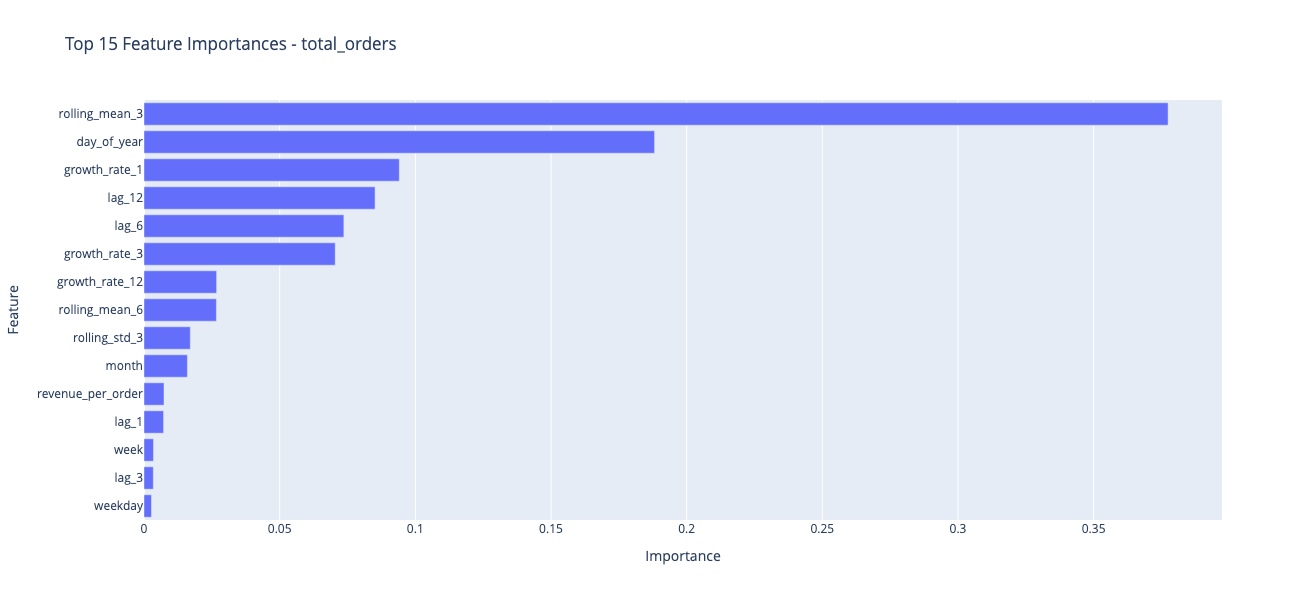


✓ Saved: results/catboost_feature_importance_total_orders.html


In [8]:
# Feature importance for first metric
metric = target_metrics[0]
model = cb_models[metric]
feature_cols = cb_feature_cols[metric]

# Get feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Features for {metric}:")
print("="*50)
print(importance_df.head(10).to_string(index=False))

# Plot feature importance
fig = go.Figure([
    go.Bar(
        y=importance_df.head(15)['feature'],
        x=importance_df.head(15)['importance'],
        orientation='h'
    )
])

fig.update_layout(
    title=f"Top 15 Feature Importances - {metric}",
    xaxis_title="Importance",
    yaxis_title="Feature",
    height=600,
    yaxis={'categoryorder': 'total ascending'}
)

fig.show()

# Save
results_dir = Path('../results')
results_dir.mkdir(exist_ok=True)
fig.write_html(results_dir / f'catboost_feature_importance_{metric}.html')
print(f"\n✓ Saved: results/catboost_feature_importance_{metric}.html")

## Section 6: Generate Forecasts

Generate predictions for validation and future periods.

In [9]:
def generate_cb_forecasts(model, df_feat, feature_cols, target_col, val_start, val_end, horizon=18):
    """
    Generate CatBoost forecasts.
    
    Note: For true future forecasts, we'd need to implement recursive forecasting
    (using predictions as lag features). For now, we'll forecast validation period
    where actual lag values are available.
    """
    # Validation period
    val_df = df_feat[(df_feat['date'] >= val_start) & (df_feat['date'] <= val_end)].copy()
    
    if len(val_df) == 0:
        print(f"  ⚠️  No validation data available for {target_col}")
        return np.array([]), np.array([])
    
    # Get features (handle any NaN)
    X_val = val_df[feature_cols]
    
    # Check for NaN in features
    if X_val.isna().any().any():
        print(f"  ⚠️  Warning: NaN values in validation features, filling with mean")
        X_val = X_val.fillna(X_val.mean())
    
    # Predict
    predictions = model.predict(X_val)
    
    return predictions, val_df['date'].values

# Generate forecasts
cb_forecasts = {}
cb_forecast_dates = {}

for metric in target_metrics:
    model = cb_models[metric]
    df_feat = cb_dataframes[metric]
    feature_cols = cb_feature_cols[metric]
    
    predictions, dates = generate_cb_forecasts(
        model, df_feat, feature_cols, metric, val_start, val_end
    )
    
    cb_forecasts[metric] = predictions
    cb_forecast_dates[metric] = dates
    
    print(f"\n{metric}:")
    print(f"  Validation forecast: {len(predictions)} months")


total_orders:
  Validation forecast: 6 months

total_km:
  Validation forecast: 6 months

total_drivers:
  Validation forecast: 6 months

revenue_total:
  Validation forecast: 6 months

external_drivers:
  Validation forecast: 6 months


## Section 7: Model Evaluation

In [10]:
def calculate_metrics(y_true, y_pred, model_name, metric_name):
    """Calculate forecast accuracy metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    return {
        'model': model_name,
        'metric': metric_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Calculate metrics
results = []

val_df = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

for metric in target_metrics:
    if len(cb_forecasts[metric]) > 0:
        y_true = val_df[metric].values
        y_pred = cb_forecasts[metric]
        
        metrics = calculate_metrics(y_true, y_pred, 'CatBoost', metric)
        results.append(metrics)

results_df = pd.DataFrame(results)

print("\nCatBoost Model Performance (Validation Period):")
print("="*80)
print(results_df.to_string(index=False))

# Compare with previous models
try:
    baseline_df = pd.read_csv('../data/processed/baseline_metrics.csv')
    prophet_df = pd.read_csv('../data/processed/prophet_metrics.csv')
    sarimax_df = pd.read_csv('../data/processed/sarimax_metrics.csv')
    
    print("\n" + "="*80)
    print("Model Comparison (MAPE):")
    print("="*80)
    
    for metric in target_metrics:
        print(f"\n{metric}:")
        
        if len(results_df[results_df['metric'] == metric]) > 0:
            cb_mape = results_df[results_df['metric'] == metric]['MAPE'].values[0]
            prophet_mape = prophet_df[prophet_df['metric'] == metric]['MAPE'].values[0]
            sarimax_mape = sarimax_df[sarimax_df['metric'] == metric]['MAPE'].values[0]
            baseline_best_mape = baseline_df[baseline_df['metric'] == metric]['MAPE'].min()
            
            print(f"  CatBoost: {cb_mape:.2f}%")
            print(f"  SARIMAX: {sarimax_mape:.2f}%")
            print(f"  Prophet: {prophet_mape:.2f}%")
            print(f"  Best Baseline: {baseline_best_mape:.2f}%")
            
            best_model = min([
                ('CatBoost', cb_mape),
                ('SARIMAX', sarimax_mape),
                ('Prophet', prophet_mape)
            ], key=lambda x: x[1])
            
            print(f"  → Best: {best_model[0]} ({best_model[1]:.2f}%)")
except Exception as e:
    print(f"\n⚠️  Could not load previous model metrics: {e}")


CatBoost Model Performance (Validation Period):
  model           metric           MAE          RMSE     MAPE
CatBoost     total_orders   3507.143311   4336.739559 2.457599
CatBoost         total_km 230216.500000 250139.218845 2.633013
CatBoost    total_drivers   3682.532471   4557.913777 2.627509
CatBoost    revenue_total 446766.167834 527744.443283 3.355742
CatBoost external_drivers    656.547852    812.703705 2.401940

Model Comparison (MAPE):

total_orders:
  CatBoost: 2.46%
  SARIMAX: 24.38%
  Prophet: 39.55%
  Best Baseline: 2.95%
  → Best: CatBoost (2.46%)

total_km:

⚠️  Could not load previous model metrics: index 0 is out of bounds for axis 0 with size 0


## Section 8: Forecast Visualization

In [11]:
# Visualize forecasts
train_df = df[df['date'] <= train_end]
val_df = df[(df['date'] >= val_start) & (df['date'] <= val_end)]

for metric in target_metrics:
    if len(cb_forecasts[metric]) == 0:
        continue
        
    fig = go.Figure()
    
    # Historical training data
    fig.add_trace(
        go.Scatter(
            x=train_df['date'],
            y=train_df[metric],
            mode='lines+markers',
            name='Historical (Training)',
            line=dict(color='black', width=2)
        )
    )
    
    # Actual validation values
    if len(val_df) > 0:
        fig.add_trace(
            go.Scatter(
                x=val_df['date'],
                y=val_df[metric],
                mode='lines+markers',
                name='Actual (Validation)',
                line=dict(color='green', width=3)
            )
        )
    
    # CatBoost forecast
    fig.add_trace(
        go.Scatter(
            x=cb_forecast_dates[metric],
            y=cb_forecasts[metric],
            mode='lines+markers',
            name='CatBoost Forecast',
            line=dict(color='purple', width=2, dash='dash')
        )
    )
    
    fig.update_layout(
        title=f"CatBoost Forecast - {metric.replace('_', ' ').title()}",
        xaxis_title="Date",
        yaxis_title=metric.replace('_', ' ').title(),
        height=600,
        hovermode='x unified'
    )
    
    fig.show()
    
    # Save
    fig.write_html(results_dir / f'catboost_forecast_{metric}.html')
    print(f"\n✓ Saved: results/catboost_forecast_{metric}.html")


✓ Saved: results/catboost_forecast_total_orders.html



✓ Saved: results/catboost_forecast_total_km.html



✓ Saved: results/catboost_forecast_total_drivers.html



✓ Saved: results/catboost_forecast_revenue_total.html



✓ Saved: results/catboost_forecast_external_drivers.html


## Section 9: Save Results

In [12]:
# Save performance metrics
output_dir = Path('../data/processed')
results_df.to_csv(output_dir / 'catboost_metrics.csv', index=False)
print(f"✓ Saved metrics: data/processed/catboost_metrics.csv")

# Save validation forecasts
if len(val_df) > 0 and len(results_df) > 0:
    forecast_output = pd.DataFrame({
        'date': val_df['date'],
        'year_month': val_df['year_month'].astype(str) if 'year_month' in val_df.columns else val_df['date'].dt.to_period('M').astype(str)
    })
    
    for metric in target_metrics:
        if len(cb_forecasts[metric]) > 0:
            forecast_output[metric] = cb_forecasts[metric]
    
    forecast_output.to_csv(output_dir / 'catboost_forecast_validation.csv', index=False)
    print(f"✓ Saved validation forecasts: data/processed/catboost_forecast_validation.csv")

print(f"\n{'='*80}")
print(f"XGBOOST MODEL COMPLETE!")
print(f"{'='*80}")
print(f"\nKey Findings:")
for metric in target_metrics:
    if len(results_df[results_df['metric'] == metric]) > 0:
        mape = results_df[results_df['metric'] == metric]['MAPE'].values[0]
        print(f"  • {metric}: MAPE = {mape:.2f}%")
print(f"\nNext: Run notebook 13 for Weighted Prophet model")

✓ Saved metrics: data/processed/catboost_metrics.csv
✓ Saved validation forecasts: data/processed/catboost_forecast_validation.csv

XGBOOST MODEL COMPLETE!

Key Findings:
  • total_orders: MAPE = 2.46%
  • total_km: MAPE = 2.63%
  • total_drivers: MAPE = 2.63%
  • revenue_total: MAPE = 3.36%
  • external_drivers: MAPE = 2.40%

Next: Run notebook 13 for Weighted Prophet model


In [13]:
def recursive_forecast_2025(model, df_full, target_col, feature_cols, num_months=12):
    """
    Generate recursive multi-step ahead forecasts for 2025.
    
    Parameters:
    -----------
    model : CatBoostRegressor
        Trained CatBoost model
    df_full : pd.DataFrame
        Full historical dataframe (2022-2024) with target column
    target_col : str
        Name of target metric
    feature_cols : list
        List of feature column names
    num_months : int
        Number of months to forecast (default 12 for full year 2025)
    
    Returns:
    --------
    pd.DataFrame
        Dataframe with date and forecast values
    """
    # Create extended dataframe with 2025 months
    last_date = df_full['date'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=num_months, freq='MS')
    
    # Combine historical and future dates
    future_df = pd.DataFrame({'date': future_dates})
    extended_df = pd.concat([df_full[['date', target_col]], future_df], ignore_index=True)
    
    # Generate temporal features for all dates
    extended_df['year'] = extended_df['date'].dt.year
    extended_df['month'] = extended_df['date'].dt.month
    extended_df['quarter'] = extended_df['date'].dt.quarter
    extended_df['week'] = extended_df['date'].dt.isocalendar().week
    extended_df['day_of_year'] = extended_df['date'].dt.dayofyear
    extended_df['weekday'] = extended_df['date'].dt.weekday
    
    # Start recursive forecasting from first future month
    first_future_idx = len(df_full)
    
    for i in range(num_months):
        current_idx = first_future_idx + i
        
        # Calculate lag features using either actual or predicted values
        if current_idx >= 1:
            extended_df.loc[current_idx, 'lag_1'] = extended_df.loc[current_idx - 1, target_col]
        if current_idx >= 3:
            extended_df.loc[current_idx, 'lag_3'] = extended_df.loc[current_idx - 3, target_col]
        if current_idx >= 6:
            extended_df.loc[current_idx, 'lag_6'] = extended_df.loc[current_idx - 6, target_col]
        if current_idx >= 12:
            extended_df.loc[current_idx, 'lag_12'] = extended_df.loc[current_idx - 12, target_col]
        
        # Calculate rolling features (need at least 3/6 previous values)
        if current_idx >= 3:
            extended_df.loc[current_idx, 'rolling_mean_3'] = extended_df.loc[current_idx-3:current_idx-1, target_col].mean()
            extended_df.loc[current_idx, 'rolling_std_3'] = extended_df.loc[current_idx-3:current_idx-1, target_col].std()
        
        if current_idx >= 6:
            extended_df.loc[current_idx, 'rolling_mean_6'] = extended_df.loc[current_idx-6:current_idx-1, target_col].mean()
        
        # Calculate growth rate features
        if current_idx >= 1 and not pd.isna(extended_df.loc[current_idx - 1, target_col]):
            if extended_df.loc[current_idx - 1, target_col] != 0:
                prev_val = extended_df.loc[current_idx - 1, target_col]
                if current_idx >= 2:
                    extended_df.loc[current_idx, 'growth_rate_1'] = (prev_val - extended_df.loc[current_idx - 2, target_col]) / extended_df.loc[current_idx - 2, target_col]
        
        if current_idx >= 3:
            extended_df.loc[current_idx, 'growth_rate_3'] = extended_df.loc[current_idx-3:current_idx, target_col].pct_change(3).iloc[-1]
        
        if current_idx >= 12:
            extended_df.loc[current_idx, 'growth_rate_12'] = extended_df.loc[current_idx-12:current_idx, target_col].pct_change(12).iloc[-1]
        
        # Extract features for prediction (fill NaN with 0 for first few predictions)
        X_pred = extended_df.loc[[current_idx], feature_cols].fillna(0)
        
        # Make prediction
        prediction = model.predict(X_pred)[0]
        
        # Store prediction
        extended_df.loc[current_idx, target_col] = prediction
    
    # Return only 2025 forecasts
    forecast_df = extended_df[extended_df['date'] >= '2025-01-01'][['date', target_col]].copy()
    
    return forecast_df

print("✓ Recursive forecasting function defined")

✓ Recursive forecasting function defined


In [14]:
# Generate 2025 forecasts for all metrics
print("="*80)
print("GENERATING 2025 RECURSIVE FORECASTS")
print("="*80)

cb_forecasts_2025 = {}

for metric in target_metrics:
    print(f"\nForecasting {metric} for 2025...")
    
    model = cb_models[metric]
    feature_cols = cb_feature_cols[metric]
    
    # Generate recursive forecast
    forecast_df = recursive_forecast_2025(model, df, metric, feature_cols, num_months=12)
    
    cb_forecasts_2025[metric] = forecast_df
    
    print(f"  ✓ Generated 12 monthly forecasts")
    print(f"  Range: {forecast_df[metric].min():.0f} - {forecast_df[metric].max():.0f}")
    print(f"  Variation: {((forecast_df[metric].max() / forecast_df[metric].min() - 1) * 100):.1f}%")

print(f"\n{'='*80}")
print(f"✓ All 2025 forecasts generated successfully!")
print(f"{'='*80}")

GENERATING 2025 RECURSIVE FORECASTS

Forecasting total_orders for 2025...


KeyError: "['revenue_per_order'] not in index"

## Section 10: Recursive Forecasting for 2025

Generate month-by-month forecasts for 2025 using recursive multi-step ahead forecasting.

**Approach:**
1. Start with actual historical values (Jan-Dec 2024)
2. Predict Jan 2025 using Dec 2024 as lag_1, Oct 2024 as lag_3, etc.
3. Predict Feb 2025 using Jan 2025 prediction as lag_1, Nov 2024 as lag_3, etc.
4. Continue recursively through all 12 months of 2025

**Key Benefit:** Captures monthly seasonality through temporal features (month=1, month=2, etc.)